In [1]:
import re
import nltk
import time
import warnings
import itertools
import matplotlib.pyplot as plt
import numpy as np

from nltk import wordnet, pos_tag
from nltk import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [2]:
categories = ['alt.atheism', 'soc.religion.christian',
              'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train',
                                  categories=categories, 
                                  shuffle=True,
                                  random_state=42,
                                  remove=['headers', 'footers', 'quotes'])
twenty_test = fetch_20newsgroups(subset='test',
                                 categories=categories, 
                                 shuffle=True, 
                                 random_state=42,
                                 remove=['headers', 'footers', 'quotes'])


In [3]:
twenty_train_list=[]
for sent in twenty_train.data:
    expr = r'[^A-za-z 0-9]'
    parser=re.compile(expr)
    tmp_string = parser.sub(r' ',sent )
    tmp_string = " ".join(tmp_string.split())
    tmp_string = tmp_string.lower()
    twenty_train_list.append(tmp_string)
print("\n", tmp_string)

twenty_test_list=[]
for sent in twenty_test.data:
    expr = r'[^A-za-z 0-9]'
    parser=re.compile(expr)
    tmp_string = parser.sub(r' ',sent )
    tmp_string = " ".join(tmp_string.split())
    tmp_string = tmp_string.lower()
    twenty_test_list.append(tmp_string)
print("\n", tmp_string)


 you forgot the smiley face i can t believe this is what they turn out at berkeley tell me you re an aberration

 yes it looks like very good indeed nope


In [4]:
sent = twenty_train.data[2]
expr = r'[^A-za-z 0-9]'
tmp_string_two=re.sub(expr,' ',sent)

print(tmp_string)

yes it looks like very good indeed nope


## CountVectorizer

In [5]:
begin = time.time() 

count_vect = CountVectorizer()
X_train_CV = count_vect.fit_transform(twenty_train_list)
print(X_train_CV.shape)
X_test_CV = count_vect.transform(twenty_test_list)
print(X_test_CV.shape)

warnings.simplefilter(action='ignore', category=FutureWarning)

svm = SGDClassifier()
svm.fit(X_train_CV, twenty_train.target)
predicted_CV = svm.predict(X_test_CV)
first_cv_metr = metrics.classification_report(twenty_test.target, predicted_CV,
                                    target_names=twenty_test.target_names)
print(first_cv_metr)

end = time.time() 
print(end-begin, 'sec')

(2257, 28864)
(1502, 28864)
                        precision    recall  f1-score   support

           alt.atheism       0.57      0.69      0.63       319
         comp.graphics       0.75      0.84      0.79       389
               sci.med       0.82      0.67      0.74       396
soc.religion.christian       0.71      0.65      0.67       398

           avg / total       0.72      0.71      0.71      1502

3.0262255668640137 sec


## TfidfVectorizer

In [6]:
begin = time.time() 

idf_vectorizer = TfidfVectorizer()
X_train_idf = idf_vectorizer.fit_transform(twenty_train_list)
print(X_train_idf.shape)
X_test_idf = idf_vectorizer.transform(twenty_test_list)
print(X_test_idf.shape)

svm = SGDClassifier()
svm.fit(X_train_idf, twenty_train.target)
predicted_idf = svm.predict(X_test_idf)
first_idf_metr = metrics.classification_report(twenty_test.target, predicted_idf,
                                    target_names=twenty_test.target_names)
print(first_idf_metr)

end = time.time() 
print(end-begin, 'sec')

(2257, 28864)
(1502, 28864)
                        precision    recall  f1-score   support

           alt.atheism       0.75      0.63      0.69       319
         comp.graphics       0.83      0.92      0.87       389
               sci.med       0.87      0.82      0.85       396
soc.religion.christian       0.78      0.83      0.80       398

           avg / total       0.81      0.81      0.81      1502

1.1823184490203857 sec


## Сравним результаты

In [7]:
print('CountVectorizer')
print(first_cv_metr)
print('TfidfVectorizer')
print(first_idf_metr)

CountVectorizer
                        precision    recall  f1-score   support

           alt.atheism       0.57      0.69      0.63       319
         comp.graphics       0.75      0.84      0.79       389
               sci.med       0.82      0.67      0.74       396
soc.religion.christian       0.71      0.65      0.67       398

           avg / total       0.72      0.71      0.71      1502

TfidfVectorizer
                        precision    recall  f1-score   support

           alt.atheism       0.75      0.63      0.69       319
         comp.graphics       0.83      0.92      0.87       389
               sci.med       0.87      0.82      0.85       396
soc.religion.christian       0.78      0.83      0.80       398

           avg / total       0.81      0.81      0.81      1502



Можем заметить, что average precision, recall, f1-score лучше у tf-idf.

_________________

In [8]:
for i in range(10):
    if (predicted_idf[i] != twenty_test.target[i]):
        print('real:', categories[twenty_test.target[i]])
        print('predicted:', categories[predicted_idf[i]])
        print('document:', twenty_test_list[i])
        print('---------------------------')

real: comp.graphics
predicted: alt.atheism
document: here we go again
---------------------------
real: comp.graphics
predicted: soc.religion.christian
document: 
---------------------------


Можно заметить, что в первой статье встречаются такие слова, как "life", "grand-mother", которые характерны для статей из обеих категорий.

Во второй статье слишком мало слов для корректного определения.

## Confusion matrix

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

Confusion matrix, without normalization


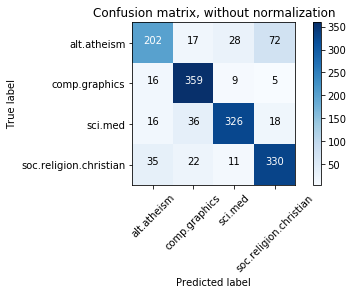

In [10]:
cnf_matrix = metrics.confusion_matrix(twenty_test.target, predicted_idf)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=twenty_train.target_names,
                      title='Confusion matrix, without normalization')

plt.show()

Наиболее частая ошибка определения категории возникает в теме религия и атеизм, что логично, так как темы весьма близкие. Лучше всего опредена компьютерная графика, т.к. имеет технические слова, по которым можно определить.

_________________________________

## Алгоритм стемминга и лемматизации

________

In [11]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [12]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [14]:
stemmer = SnowballStemmer(language='english')

twenty_train_stem=[]
for elem in twenty_train_list:
    twenty_train_stem.append(' '.join([stemmer.stem(word) for word in elem.split()]))
print(twenty_train_stem[0])

doe anyon know of a good way standard pc applic pd util to convert tif img tga file into laserjet iii format we would also like to do the same convert to hpgl hp plotter file pleas email ani respons is this the correct group thank in advanc michael


In [15]:
twenty_test_stem=[]
for elem in twenty_test_list:
    twenty_test_stem.append(' '.join([stemmer.stem(word) for word in elem.split()]))
print(twenty_test_stem[0])

as i recal from my bout with kidney stone there isn t ani medic that can do anyth about them except reliev the pain either they pass or they have to be broken up with sound or they have to be extract surgic when i was in the x ray tech happen to mention that she d had kidney stone and children and the childbirth hurt less


In [16]:
begin = time.time()

idf_vectorizer = TfidfVectorizer()
X_train_idf = idf_vectorizer.fit_transform(twenty_train_stem)
print(X_train_idf.shape)
X_test_idf = idf_vectorizer.transform(twenty_test_stem)
print(X_test_idf.shape)

svm = SGDClassifier()
svm.fit(X_train_idf, twenty_train.target)
predicted_idf = svm.predict(X_test_idf)
print(metrics.classification_report(twenty_test.target, predicted_idf,
                                    target_names=twenty_test.target_names))

end = time.time()
print(end-begin,'sec')

(2257, 20952)
(1502, 20952)
                        precision    recall  f1-score   support

           alt.atheism       0.76      0.65      0.70       319
         comp.graphics       0.84      0.90      0.87       389
               sci.med       0.85      0.84      0.85       396
soc.religion.christian       0.77      0.80      0.79       398

           avg / total       0.81      0.81      0.81      1502

0.7745537757873535 sec


_________________________

In [17]:
def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN

In [18]:
lemmatizer = WordNetLemmatizer()
def my_lemmatizer(sent):
    tokenized_sent = sent.split()
    pos_tagged = [(word, get_wordnet_pos(tag))
                 for word, tag in pos_tag(tokenized_sent)]
    return ' '.join([lemmatizer.lemmatize(word, tag)
                    for word, tag in pos_tagged])

In [19]:
print(len(twenty_train_list))
print(len(twenty_test_list))

2257
1502


In [20]:
twenty_train_lem=[]
for elem in twenty_train_list:
     twenty_train_lem.append(my_lemmatizer(elem))
print(twenty_train_lem[0])

do anyone know of a good way standard pc application pd utility to convert tif img tga file into laserjet iii format we would also like to do the same converting to hpgl hp plotter file please email any response be this the correct group thanks in advance michael


In [21]:
twenty_test_lem=[]
for elem in twenty_test_list:
     twenty_test_lem.append(my_lemmatizer(elem))
print(twenty_test_lem[0])

a i recall from my bout with kidney stone there isn t any medication that can do anything about them except relieve the pain either they pass or they have to be break up with sound or they have to be extract surgically when i be in the x ray tech happen to mention that she d have kidney stone and child and the childbirth hurt less


In [22]:
begin = time.time()

idf_vectorizer = TfidfVectorizer()
X_train_idf = idf_vectorizer.fit_transform(twenty_train_lem)
print(X_train_idf.shape)
X_test_idf = idf_vectorizer.transform(twenty_test_lem)
print(X_test_idf.shape)

svm = SGDClassifier()
svm.fit(X_train_idf, twenty_train.target)
predicted_idf = svm.predict(X_test_idf)
print(metrics.classification_report(twenty_test.target, predicted_idf,
                                    target_names=twenty_test.target_names))

end = time.time()
print(end-begin,'sec')

(2257, 24670)
(1502, 24670)
                        precision    recall  f1-score   support

           alt.atheism       0.74      0.66      0.70       319
         comp.graphics       0.84      0.90      0.87       389
               sci.med       0.88      0.83      0.86       396
soc.religion.christian       0.77      0.83      0.80       398

           avg / total       0.81      0.81      0.81      1502

0.7545645236968994 sec


Сравним размерность признакового пространства, точность алгоритма и время работы.

Для tfidfVectorizer без стемминга и лемминга:

- Размер признакового пространства - 28864
- Средняя точность по всем метрикам качества - 0.81
- Время работы - 0.79 секунд

Для tfidfVectorizer со стеммингом:

- Размер признакового пространства - 20952
- Средняя точность по всем recall и f1-score качества - 0.81, по precision - 0.82
- Время работы - 0.76 секунд

Для tfidfVectorizer с леммингом:

- Размер признакового пространства - 24670
- Средняя точность по всем метрикам качества - 0.81
- Время работы - 0.71 секунд

Заметим, что стемминг и лемминг уменьшают размер признакового пространства, причем в нашем случае, стемминг уменьшает сильнее.

Время работы алгоритмы уменьшается вследствии применения стемминга или лемминга.

Точность практически не изменяется (кроме увеличения presicion для стемминга)

### Проверка при ограничении на частоту слов и стоп-слова

In [24]:
begin = time.time()

idf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_idf = idf_vectorizer.fit_transform(twenty_train_list)
print(X_train_idf.shape)
X_test_idf = idf_vectorizer.transform(twenty_test_list)
print(X_test_idf.shape)

svm = SGDClassifier()
svm.fit(X_train_idf, twenty_train.target)
predicted_idf = svm.predict(X_test_idf)
print(metrics.classification_report(twenty_test.target, predicted_idf,
                                    target_names=twenty_test.target_names))

end = time.time()
print(end-begin,'sec')

(2257, 28558)
(1502, 28558)
                        precision    recall  f1-score   support

           alt.atheism       0.81      0.60      0.69       319
         comp.graphics       0.82      0.93      0.87       389
               sci.med       0.87      0.84      0.86       396
soc.religion.christian       0.77      0.86      0.81       398

           avg / total       0.82      0.82      0.81      1502

0.7735557556152344 sec


In [25]:
begin = time.time()

idf_vectorizer = TfidfVectorizer(max_df=0.1)
X_train_idf = idf_vectorizer.fit_transform(twenty_train_list)
print(X_train_idf.shape)
X_test_idf = idf_vectorizer.transform(twenty_test_list)
print(X_test_idf.shape)

svm = SGDClassifier()
svm.fit(X_train_idf, twenty_train.target)
predicted_idf = svm.predict(X_test_idf)
print(metrics.classification_report(twenty_test.target, predicted_idf,
                                    target_names=twenty_test.target_names))

end = time.time()
print(end-begin,'sec')

(2257, 28735)
(1502, 28735)
                        precision    recall  f1-score   support

           alt.atheism       0.77      0.66      0.71       319
         comp.graphics       0.84      0.92      0.88       389
               sci.med       0.88      0.82      0.85       396
soc.religion.christian       0.77      0.84      0.80       398

           avg / total       0.82      0.82      0.81      1502

0.7765529155731201 sec


In [26]:
begin = time.time()

idf_vectorizer = TfidfVectorizer(max_df=0.01)
X_train_idf = idf_vectorizer.fit_transform(twenty_train_list)
print(X_train_idf.shape)
X_test_idf = idf_vectorizer.transform(twenty_test_list)
print(X_test_idf.shape)

svm = SGDClassifier()
svm.fit(X_train_idf, twenty_train.target)
predicted_idf = svm.predict(X_test_idf)
print(metrics.classification_report(twenty_test.target, predicted_idf,
                                    target_names=twenty_test.target_names))

end = time.time()
print(end-begin,'sec')

(2257, 27348)
(1502, 27348)
                        precision    recall  f1-score   support

           alt.atheism       0.76      0.53      0.62       319
         comp.graphics       0.90      0.83      0.86       389
               sci.med       0.74      0.84      0.78       396
soc.religion.christian       0.70      0.82      0.75       398

           avg / total       0.77      0.77      0.76      1502

0.8225226402282715 sec


In [27]:
begin = time.time()

idf_vectorizer = TfidfVectorizer(min_df=0.001)
X_train_idf = idf_vectorizer.fit_transform(twenty_train_list)
print(X_train_idf.shape)
X_test_idf = idf_vectorizer.transform(twenty_test_list)
print(X_test_idf.shape)

svm = SGDClassifier()
svm.fit(X_train_idf, twenty_train.target)
predicted_idf = svm.predict(X_test_idf)
print(metrics.classification_report(twenty_test.target, predicted_idf,
                                    target_names=twenty_test.target_names))

end = time.time()
print(end-begin,'sec')

(2257, 9189)
(1502, 9189)
                        precision    recall  f1-score   support

           alt.atheism       0.79      0.63      0.70       319
         comp.graphics       0.82      0.91      0.86       389
               sci.med       0.87      0.80      0.84       396
soc.religion.christian       0.76      0.86      0.81       398

           avg / total       0.81      0.81      0.81      1502

0.8485102653503418 sec


Заметим, что ограничение снизу, если отсекает много слов, то в отрицательную сторону влияет на качество, уменьшает время выполнения

Ограничение сверху улучшило результат, уменьшает время выполнения

Отсечение стоп-слов улучшило результат, уменьшает время выполнения

In [29]:
begin = time.time()

idf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.1, min_df=0.001)
X_train_idf = idf_vectorizer.fit_transform(twenty_train_list)
print(X_train_idf.shape)
X_test_idf = idf_vectorizer.transform(twenty_test_list)
print(X_test_idf.shape)

svm = SGDClassifier()
svm.fit(X_train_idf, twenty_train.target)
predicted_idf = svm.predict(X_test_idf)
print(metrics.classification_report(twenty_test.target, predicted_idf,
                                    target_names=twenty_test.target_names))

end = time.time()
print(end-begin,'sec')

(2257, 8868)
(1502, 8868)
                        precision    recall  f1-score   support

           alt.atheism       0.76      0.66      0.70       319
         comp.graphics       0.82      0.90      0.86       389
               sci.med       0.86      0.83      0.84       396
soc.religion.christian       0.80      0.84      0.82       398

           avg / total       0.81      0.81      0.81      1502

0.7345778942108154 sec


Применив все вместе, заметим, что алгоритм работает быстрее, чем во всех проведенных до этого экспериментах, качетсво наивысшее, размер признакого пространства уменьшился с 28+ тысяч до 8800. То есть почти 20 тысяч выделенных изначально признаков совсем незначительно влияют на качество классификации.